0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9


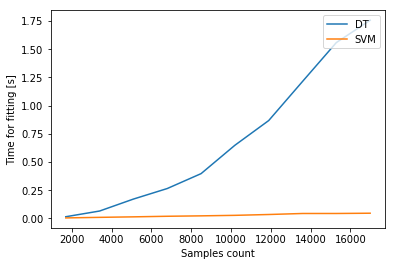

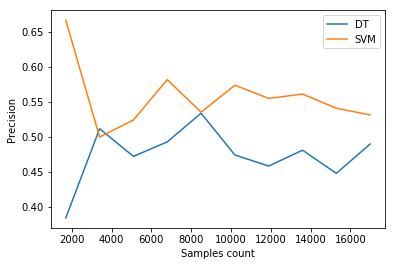

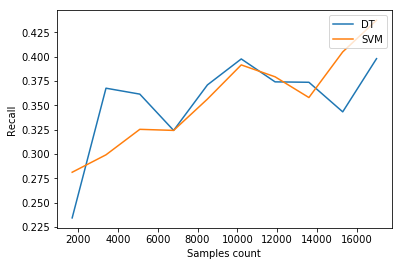

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve

matrix_helper = MatrixHelper()

# Read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_current.pickle')

precision_list_dt = []
precision_list_svm = []
recall_list_dt = []
recall_list_svm = []
time_list_dt = []
time_list_svm = []
relevant_samples = []

for i in range(10):
    for model in ['DT', 'LinearSVC']:
        relevant = (matrices[0].shape[0] / 10.0) * (i + 1)
        # Instantiate Prediction Helper Class and predict values for compare matrix with an SVM
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type=model, crop_matrix=relevant)
        compare_matrix = prediction_helper.get_compare_matrix()

        # Compute Precision-Recall
        precision, recall, thresholds = precision_recall_curve(np.array(compare_matrix[:, 2], dtype='f'), np.array(compare_matrix[:, 1], dtype='f'))
        
        if model == 'DT':
            relevant_samples.append(relevant)
            precision_list_dt.append(precision[1])
            recall_list_dt.append(recall[1])
            time_list_dt.append(prediction_helper.time)
        else:
            precision_list_svm.append(precision[1])
            recall_list_svm.append(recall[1])
            time_list_svm.append(prediction_helper.time)
        print(i)


    
figure_time = plt.figure()

plt.xlabel('Samples count')
plt.ylabel('Time for fitting [s]')
dt, = plt.plot(relevant_samples, time_list_dt, label="DT")
svm, = plt.plot(relevant_samples, time_list_svm, label="SVM")
plt.legend(handles=[dt, svm], loc=1)

figure_precision = plt.figure()

plt.xlabel('Samples count')
plt.ylabel('Precision')
dt, = plt.plot(relevant_samples, precision_list_dt, label="DT")
svm, = plt.plot(relevant_samples, precision_list_svm, label="SVM")
plt.legend(handles=[dt, svm], loc=1)

figure_recall = plt.figure()

plt.xlabel('Samples count')
plt.ylabel('Recall')
dt, = plt.plot(relevant_samples, recall_list_dt, label="DT")
svm, = plt.plot(relevant_samples, recall_list_svm, label="SVM")
plt.legend(handles=[dt, svm], loc=1)


figure_time.savefig('outputs/dt-vs-svm-time.pdf')
figure_precision.savefig('outputs/dt-vs-svm-precision.pdf')
figure_recall.savefig('outputs/dt-vs-svm-recall.pdf')


